## Lecture17 - Motor Control
### Introduction to modeling and simulation of human movement
https://github.com/BMClab/bmc/blob/master/courses/ModSim2018.md

Desiree Miraldo  

* Lecture 17: Human body balance - Inverted pendulum

Find the control rule so that the angle of inverted pendulum is around 5 deg with peak-to-peak variation of 0.5 deg

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from Muscle1 import Muscle

%matplotlib inline 
#notebook

### Subject's anthropometrics

From Thelen(2003) - dorsiflexors:

Using BSP values from Dempster's model adapted by Winter (2009), available in [BodySegmentParameters.ipynb](https://github.com/BMClab/bmc/blob/master/notebooks/BodySegmentParameters.ipynb)

In [2]:
m = 75 #kg

"""
# g = 9.81 #(m/s^2)
Lfoot = 26e-2 #(m)
mfoot = 0.0145*m #0.0145 from column Mass (kg)
Rcm = 0.5* Lfoot #0.5 from column CM prox (m)
Ifoot = mfoot*(.69*Lfoot)**2 #0.690 from column Rg prox (kg*m^2)
"""
hbody = 175e-2 #(m)
#Rhcm = .5*hbody #distance from ankle joint to CoM
Rhcm = .85
Ibody = 4/3*m*Rhcm**2 


### Initial conditions

In [3]:
phi = 5*np.pi/180 #start as 0 degree flexion (rad)
phid = 0 #zero velocity

t0 = 0 #Initial time
tf = 25 #Final Time
h = 1e-4 #integration step size and step counter

In [4]:
t = np.arange(t0,tf,h)
F = np.empty([2,t.shape[-1]])
Fkpe = np.empty([2,t.shape[-1]])
FiberLen = np.empty([2,t.shape[-1]])
TendonLen = np.empty([2,t.shape[-1]])
fiberVelocity = np.empty([2,t.shape[-1]])
a_dynamics = np.empty([2,t.shape[-1]])
phi_dynamics = np.empty(t.shape)
moment     = np.empty(t.shape)

#### Activation dynamics parameters

In [5]:
# defining u (Initial conditional for Brain's activation)
form = 'step'

def createinput_u(form,t,h=.01,plot=True):
    if (form == 'sinusoid'):
        u = .2*np.sin(np.pi*t) +.7
    elif (form == 'step'):
        u = np.ones[2,t.shape[-1]]*h
        u[:int(1/h)] = 0
        u[int(1/h):int(3/h)] = 1

    elif (form == 'pulse'):
        u = np.ones[2,t.shape[-1]]*h
        u[int(1/h):int(3/h)] = 1

    if plot:
        plt.figure()
        plt.plot(u)
        plt.title('u wave form')
    return u   

#u = createinput_u(form,h)
u = np.ones(t.shape[-1])/1

#### Coeficients from Elias(2014)

In [6]:
#parameters from Elias(2014) (meter/deg^ind)
A_TA = np.array([30.60,-7.44e-2,-1.41e-4,2.42e-6,1.50e-8])*1e-2 
B_TA = np.array([4.30,1.66e-2,-3.89e-4,-4.45e-6,-4.34e-8])*1e-2
A_SO = np.array([32.30, 7.22e-2, -2.24e-4, -3.15e-6, 9.27e-9])*1e-2
B_SO = np.array([-4.10, 2.57e-2, 5.45e-4, -2.22e-6, -5.50e-9])*1e-2
A_MG = np.array([46.40, 7.48e-2, -1.13e-4, -3.50e-6, 7.35e-9])*1e-2
A_MG = np.array([24.30, 1.30e-2, 6.08e-4, -1.87e-6, -1.02e-8])*1e-2
A_LG = np.array([45.50, 7.62e-2, -1.25e-4, -3.55e-6, 7.65e-9])*1e-2 
B_LG = np.array([24.40, 1.44e-2, 6.18e-4, -1.94e-6, -1.02e-8])*1e-2 

In [7]:
# Using muscle specific parameters from Thelen(2003) - Table 2

dorsiflexor = Muscle(Lce_o=.09, Lslack=2.4, alpha=7*np.pi/180, Fmax=1400, dt=h)
soleus = Muscle(Lce_o=.049, Lslack=5.9, alpha=25*np.pi/180, Fmax=3150, dt=h)
#soleus = Muscle(Lce_o=.03, Lslack=8.8, alpha=25*np.pi/180, Fmax=3150, dt=h)
gastroc = Muscle(Lce_o=.05, Lslack=8.3, alpha=14*np.pi/180, Fmax=1750, dt=h)
plantarflexor = Muscle(Lce_o=.031, Lslack=10, alpha=12*np.pi/180, Fmax=3150, dt=h)

In [8]:
soleus.Fmax = soleus.Fmax + gastroc.Fmax + plantarflexor.Fmax
soleus.Fmax

8050

In [9]:
phiRef = 5*np.pi/180 #(deg)
SORef = 0.037
TARef = 0.085

kpTA = 700
kdTA = 80

kpSO = 300
kdSO = 200

In [10]:
#dorsiflexor.Lnorm_ce = .087/dorsiflexor.Lce_o
#soleus.Lnorm_ce = .087/soleus.Lce_o
dorsiflexor.Lnorm_ce = ((A_TA[0]-dorsiflexor.Lslack)/np.cos(dorsiflexor.alpha))/dorsiflexor.Lce_o
soleus.Lnorm_ce = ((A_SO[0]-soleus.Lslack)/np.cos(soleus.alpha))/soleus.Lce_o


## Functions

In [11]:
def totalMuscleLength(phi,A):
    '''
    Compute length Muscle+tendon - Eq. 8 from Elias(2014)
    
    Inputs:
        phi = angle of ankle (rad)
        A = parameters from Elias(2014) (meter/deg^ind)
    Output:
        Lm = length Muscle+tendon
    
    '''
    phi = phi*180/np.pi #rad2deg
    
    Lm = 0
    for i in range(len(A)):
        Lm += A[i]*(phi**i)
    
    return Lm   
    

In [12]:
def momentArm(phi,B):
    '''
    Compute moment arm of muscle - Eq. 9 from Elias(2014)
    
    Inputs:
        phi = angle of ankle (rad)
        B = parameters from Elias(2014) (meter/deg^ind)
    Output:
        Rf = moment arm
    '''
    
    phi = phi*180/np.pi
    
    Rf = 0
    for i in range(len(B)):
        Rf += B[i]*(phi**i) #Eq. 9 from Elias(2014)
    
    return Rf   
    

In [13]:
def momentJoint(Rf_TA, Fnorm_tendon_TA, Fmax_TA, Rf_SOL, Fnorm_tendon_SOL, Fmax_SOL, Rcm,m, phi):
    
    g = 9.81 #(m/s^2)
    
    '''
    Inputs:
        Rf = Moment arm
        Fnorm_tendon = Normalized tendon force
        m = Segment Mass
        g = Acelleration of gravity
        Fmax= maximal isometric force
        phi = angle (deg)
    Output:
        M = Total moment with respect to joint
    '''
    M = (-.65*m*g*Rcm*phi
        +Rf_TA*Fnorm_tendon_TA*Fmax_TA + Rf_SOL*Fnorm_tendon_SOL*Fmax_SOL 
        + m*g*Rcm*np.sin(phi))
    return M

In [14]:
def angularAcelerationJoint(M,I):
    '''
    Inputs:
        M = Total moment with respect to joint
        I = Moment of Inertia
    Output:
        phidd= angular aceleration of the joint
    '''
    phidd = M/I
    return phidd

### Check initial conditions

## Simulation

In [15]:
noise = 1000*np.random.randn(len(t))

for i in range(len(t)):
    
    LmTA =  totalMuscleLength(phi,A_TA)
    LmSOL =  totalMuscleLength(phi,A_SO)
    
    # Controll brain activation
    eTA = TARef - dorsiflexor.Lnorm_ce*dorsiflexor.Lce_o
    eSOL = SORef - soleus.Lnorm_ce*soleus.Lce_o
    
    if eTA > 0:
        uTA = .01
    else:
        uTA = max(min(1,-(kpTA*eTA - kdTA*dorsiflexor.Lnorm_cedot*dorsiflexor.Lce_o)),.01)
    
    if eSOL > 0:
        uSOL = .01
    else:
        uSOL = max(min(1,-(kpSO*eSOL - kdSO*soleus.Lnorm_cedot*soleus.Lce_o)),.01)
    
    
    dorsiflexor.updateMuscle(Lm=LmTA, u=uTA)
    soleus.updateMuscle(Lm=LmSOL, u=uSOL)
  
    
    #Compute MomentJoint
    RfTA = momentArm(phi,B_TA) #moment arm
    RfSOL = momentArm(phi,B_SO) #moment arm
      
    M = momentJoint(RfTA,dorsiflexor.Fnorm_tendon,dorsiflexor.Fmax,RfSOL,soleus.Fnorm_tendon,soleus.Fmax,Rhcm,m,phi)
    Mnoise = M + noise[i]
    
    #Compute Angular Aceleration Joint
    phidd = angularAcelerationJoint(Mnoise,Ibody)
    
    #Euler integration steps 
    phid = phid + h*phidd
    phi  = phi +h*phid
    

    # Store variables in vectors - dorsiflexor (Tibialis Anterior)
    F[0,i] = dorsiflexor.Fnorm_tendon*dorsiflexor.Fmax
    Fkpe[0,i] = dorsiflexor.Fnorm_kpe*dorsiflexor.Fmax
    FiberLen[0,i] = dorsiflexor.Lnorm_ce*dorsiflexor.Lce_o
    TendonLen[0,i] = dorsiflexor.Lnorm_see*dorsiflexor.Lce_o
    a_dynamics[0,i] = dorsiflexor.a
    fiberVelocity[0,i] = dorsiflexor.Lnorm_cedot*dorsiflexor.Lce_o
    
    # Store variables in vectors - soleus
    F[1,i] = soleus.Fnorm_tendon*soleus.Fmax
    Fkpe[1,i] = soleus.Fnorm_kpe*soleus.Fmax
    FiberLen[1,i] = soleus.Lnorm_ce*soleus.Lce_o
    TendonLen[1,i] = soleus.Lnorm_see*soleus.Lce_o
    a_dynamics[1,i] = soleus.a
    fiberVelocity[1,i] = soleus.Lnorm_cedot*soleus.Lce_o
    
    #joint
    phi_dynamics[i] = phi
    moment[i] = M

## Plots 

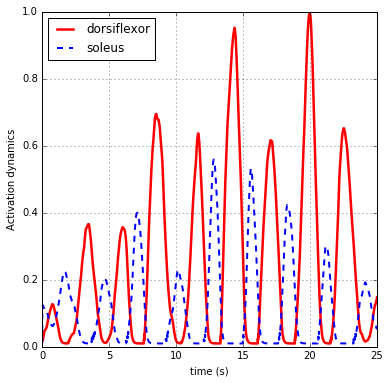

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,a_dynamics[0,:],'r',lw=2.5,label='dorsiflexor')
ax.plot(t,a_dynamics[1,:],'--b',lw=2,label='soleus')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Activation dynamics');
ax.legend(loc='best')

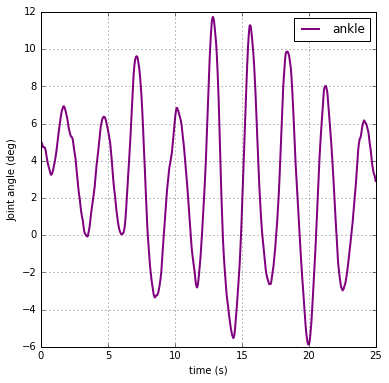

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,phi_dynamics*180/np.pi,'purple',lw=2,label='ankle')

plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Joint angle (deg)');
ax.legend(loc='best')

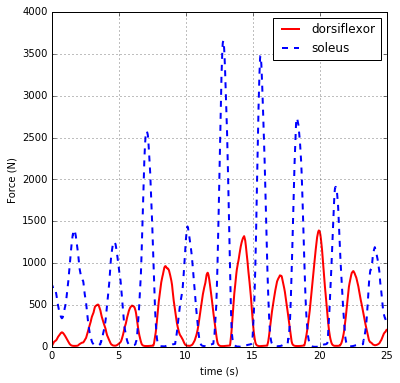

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,F[0,:],'r',lw=2,label='dorsiflexor')
ax.plot(t,F[1,:],'--b',lw=2,label='soleus')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Force (N)');
ax.legend(loc='best')

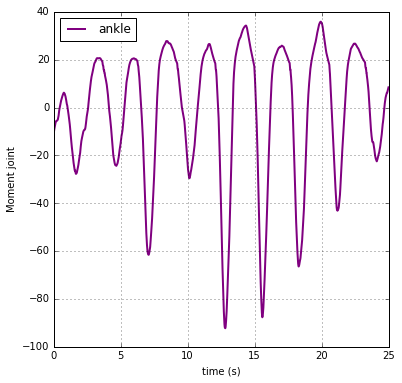

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,moment,'purple',lw=2,label='ankle')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Moment joint');
ax.legend(loc='best')

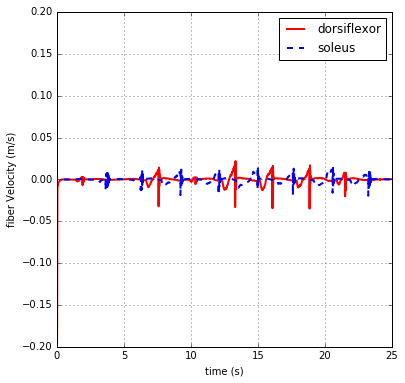

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,fiberVelocity[0,:],'r',lw=2,label='dorsiflexor')
ax.plot(t,fiberVelocity[1,:],'--b',lw=2,label='soleus')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('fiber Velocity (m/s)');
ax.legend(loc='best')

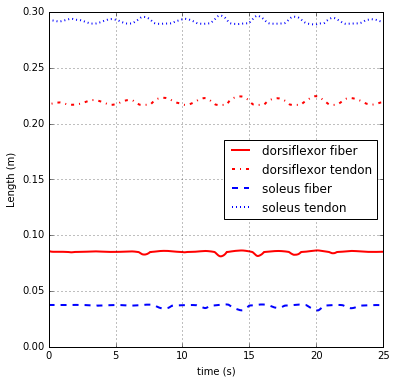

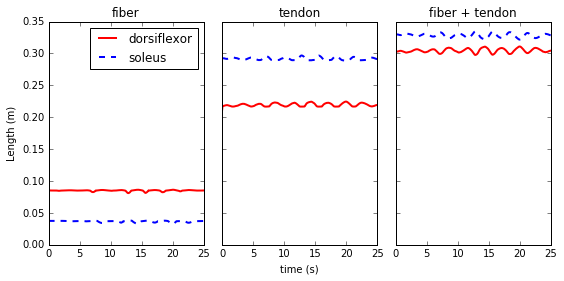

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,FiberLen[0,:],'r',lw=2,label='dorsiflexor fiber')
ax.plot(t,TendonLen[0,:],'-.r',lw=2,label='dorsiflexor tendon')

ax.plot(t,FiberLen[1,:],'--b',lw=2,label='soleus fiber')
ax.plot(t,TendonLen[1,:],':b',lw=2,label='soleus tendon')

plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Length (m)')
ax.legend(loc='best')


fig, ax = plt.subplots(1, 3, figsize=(9,4), sharex=True, sharey=True)
plt.subplots_adjust(wspace=.12, hspace=None,left=None, bottom=None, right=None, top=None,)
ax[0].plot(t,FiberLen[0,:],'r',lw=2,label='dorsiflexor')
ax[1].plot(t,TendonLen[0,:],'r',lw=2,label='dorsiflexor')
ax[2].plot(t,FiberLen[0,:] + TendonLen[0,:],'r',lw=2,label='dorsiflexor')

ax[0].plot(t,FiberLen[1,:],'--b',lw=2,label='soleus')
ax[1].plot(t,TendonLen[1,:],'--b',lw=2,label='soleus')
ax[2].plot(t,FiberLen[1,:] + TendonLen[1,:],'--b',lw=2,label='soleus')

ax[1].set_xlabel('time (s)')
ax[0].set_ylabel('Length (m)');

ax[0].set_title('fiber')
ax[1].set_title('tendon')
ax[2].set_title('fiber + tendon')


ax[0].legend(loc='best')